# Data crawling

We first crawl movie reviews of Verified Audience on Rotten Tomatoes. These reviews provide star ratings which allow for easy and automatic labeling.

In [2]:
import time

import pandas as pd
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

In [ ]:
def data_source(html_source, n=10):
    """
    This function creates a web driver to access a movie review page on rottentomatoes
    and performs n clicks on the load more button to load more reviews beyond the display limit.
    html_source: str, the url of the movie review page
    n: int, the number of times to click the load more button
    """
    
    # initialize the web driver
    driver = webdriver.Chrome()
    driver.get(html_source)
    driver.implicitly_wait(50)

    try:
        # Click the load button
        clickable = driver.find_element(By.CLASS_NAME, 'load-more-container')
        
        # Click it n times to load more content
        for _ in range(n):
            action_chains = ActionChains(driver)
            action_chains.click(clickable).perform()
            WebDriverWait(driver, 100).until(EC.element_to_be_clickable((By.CLASS_NAME, 'load-more-container')))
            time
            clickable = driver.find_element(By.CLASS_NAME, 'load-more-container')  # Update clickable element
    except NoSuchElementException:
        # If no more load-more button is found, stop clicking
        pass
    
    driver.implicitly_wait(2)
    return driver

In [ ]:
def collect_data(driver):
    """
    This function collects the star ratings and comments from the movie review page given the web driver.
    driver: the web driver to the movie review page
    """
    # Find all comments
    comment_elements = driver.find_elements(By.CSS_SELECTOR, 'p.audience-reviews__review.js-review-text[data-qa="review-text"]')
    comment_texts = [comment.text.strip() for comment in comment_elements]

    # Find the star elements and extract the star ratings
    html_content = driver.page_source
    soup = BeautifulSoup(html_content, "html.parser")
    stars = soup.find_all("span", class_="audience-reviews__score")
    # ratings = number of full stars + 0.5 * number of half stars
    star_ratings = [len(star.find_all("span", class_="star-display__filled")) +
                    0.5 * len(star.find_all("span", class_="star-display__half"))
                    for star in stars]
    
    df = pd.DataFrame({"star": star_ratings, "Verfied_Audience_Comment":comment_texts})
    df.reset_index(drop=True , inplace=True)
    
    driver.quit()
    time.sleep(3)
    return df

In [ ]:
# Read the movie urls stored in a csv file
# can crawl more movies by adding more urls to the csv file
movie_urls = pd.read_csv("Movie_List.csv")
movie_urls

In [ ]:
# collect reviews and ratings for each movie in the list
df_list = []
for url in movie_urls['Title']:
    try:
        driver = data_source(url)
        df = collect_data(driver)
        print(url, "success", f'{df.shape[0]} reviews collected')
        df_list.append(df)
    except:
        continue

In [ ]:
concat_df = pd.concat(df_list, ignore_index=True)
concat_df

In [ ]:
# label the sentiment of the reviews
# stars < 3: negative (-1)
# 3 <= stars < 4: neutral (0)
# stars >= 4: positive (1)
def label_sentiment(df, column):
    df['label'] = 0
    df.loc[df[column] < 3, 'label'] = -1
    df.loc[(3 <= df[column]) & (df['star']< 4), 'label'] = 0
    df.loc[df[column] >= 4, 'label'] = 1
    
    return df

In [ ]:
# label the sentiment of the reviews and save the data
concat_df = label_sentiment(concat_df, 'star')
concat_df.to_csv("action_movie.csv", index= False)

# Data cleaning

We then clean the collected data. The cleaning process involves 3 steps:
1. Remove special characters but keep basic punctuation.
2. Remove non-english reviews
3. Handle missing data (if any) and remove duplicates (if any)

In [1]:
import pandas as pd
import regex as re
from langdetect import detect, LangDetectException
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [2]:
# Load the data
data = pd.read_csv('movie_reviews.csv')

# function to remove special characters but keep basic punctuation
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    return cleaned_text

# apply the cleaning function
data['Verfied_Audience_Comment'] = data['Verfied_Audience_Comment'].apply(clean_text)

# function to detect English language
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# filter out non-English reviews
data = data[data['Verfied_Audience_Comment'].apply(is_english)]

In [3]:
# Convert text to lowercase
data['Verfied_Audience_Comment'] = data['Verfied_Audience_Comment'].str.lower()

# not removing stopwords works better for sentiment analysis
# data['Verfied_Audience_Comment'] = data['Verfied_Audience_Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Check for any missing values and drop
data.dropna(inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Show cleaned data
data.head(5)

,star,Verfied_Audience_Comment,label
0,3.5,a movie that is carried by its two charismatic...,0
1,3.5,if your an action person this is for you. pure...,0
2,0.5,"wow, how did this get into the movie theaters ...",-1
4,4.0,"cool action and story, great summer blockbuster",1
5,4.0,lots of fun dialogand great action. ill gladly...,1


In [4]:
data.shape

(9894, 3)

In [5]:
# Save the cleaned DataFrame to a CSV file
data.to_csv('cleaned_movie_reviews.csv', index=False)

# Feature Engineering with BERT

After the data is cleaned, we proceed to vectorize the data to prepare it for training machine learning models. We will use BERT -- a modern embedding method that transforms each sequence of words to a dense, multi-dimensional vector. This vectorized data will then be used to train machine learning models for movie review sentiment analysis.

In [6]:
import pandas as pd
import numpy as np
import torch
import random
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertTokenizer, BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

/home/tungnd/miniconda3/envs/bbo-llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# load data
df = pd.read_csv('cleaned_movie_reviews.csv')
df.head()

,star,Verfied_Audience_Comment,label
0,3.5,a movie that is carried by its two charismatic...,0
1,3.5,if your an action person this is for you. pure...,0
2,0.5,"wow, how did this get into the movie theaters ...",-1
3,4.0,"cool action and story, great summer blockbuster",1
4,4.0,lots of fun dialogand great action. ill gladly...,1


In [8]:
# we load the DistilBERT model and tokenizer from the transformers library
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# for better performance with the cost of increased runtime, we can use the BERT model instead of the DistilBERT model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

In [9]:
# we tokenize each review into a sequence of word indices in a fixed vocabulary
tokenized = df['Verfied_Audience_Comment'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


In [10]:
tokenized[0][:5] # first 5 word indices of the first review

[101, 1037, 3185, 2008, 2003]

In [11]:
# find reviews with length greater than 512
skipped_indices = [i for i, x in enumerate(tokenized) if len(x) > 512]
len(skipped_indices)

36

In [12]:
# drop reviews with length greater than 512
tokenized = tokenized.drop(skipped_indices)

The BERT model can vectorize multiple reviews at once (called batching) but all reviews must have the same length to pass through the model. Therefore, we pad all reviews to a fixed length with a dummy token (indexed 0 in the vocabulary). To do that, we first find the length of the longest review in the data, and at the same time filter out any review that is longer than what the model can handle.

In [13]:
max_len = 0 # the maximum sequence length of the reviews
for i, review in enumerate(tokenized.values):
    if len(review) > max_len:
        max_len = len(review)

# pad the sequences to the maximum length
padded = np.array([review + [0]*(max_len-len(review)) for i, review in enumerate(tokenized.values)])

In [14]:
print (padded.shape)

(9858, 493)


The maximum length of reviews is 493.

In [15]:
# verify that padding works as expected
print ('Before padding:', tokenized[0][:50])
print ('After padding:', padded[0][:50])

Before padding: [101, 1037, 3185, 2008, 2003, 3344, 2011, 2049, 2048, 23916, 5260, 1010, 1998, 8909, 6935, 3449, 3676, 2004, 2092, 1012, 102]
After padding: [  101  1037  3185  2008  2003  3344  2011  2049  2048 23916  5260  1010
  1998  8909  6935  3449  3676  2004  2092  1012   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


Because the padded tokens are dummy, we want the BERT model to ignore these tokens when embedding each review. We do this by masking out these tokens when passing the padded tokenized reviews through the model. 

In [16]:
attention_mask = np.where(padded != 0, 1, 0) # 0 means ignore
attention_mask = torch.tensor(attention_mask)
input_ids = torch.tensor(padded)

In [17]:
print ('Input ids:', input_ids[0][:50])
print ('Attention mask:', attention_mask[0][:50])

Input ids: tensor([  101,  1037,  3185,  2008,  2003,  3344,  2011,  2049,  2048, 23916,
         5260,  1010,  1998,  8909,  6935,  3449,  3676,  2004,  2092,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [18]:
# pass the input ids and attention mask to the model to get the embedding for each review
batch_size = 512
embeddings = []
with torch.no_grad():
    for i in tqdm(range(0, len(input_ids), batch_size)):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_mask = attention_mask[i:i+batch_size]
        batch_last_hidden_states = model(batch_input_ids, attention_mask=batch_attention_mask)
        embeddings.append(batch_last_hidden_states[0][:,0,:].numpy())
embeddings = np.concatenate(embeddings)

100%|██████████| 20/20 [13:31<00:00, 40.57s/it]


In [19]:
embeddings.shape

(9858, 768)

# Sentiment Analysis

Now we have vectorized the reviews to numpy arrays, we can use standard machine learning algorithms in sklearn to classify each review to one of 3 sentiment labels.

In [20]:
# get the labels and remove the skipped reviews
labels = df['label'].drop(skipped_indices)
len(labels), len(embeddings)

(9858, 9858)

<BarContainer object of 3 artists>

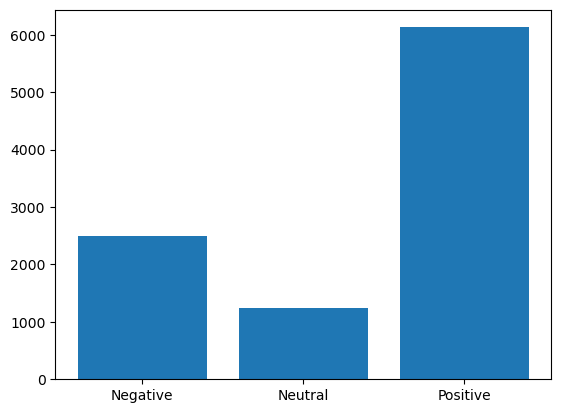

In [21]:
# plot the distribution of the labels
import matplotlib.pyplot as plt
plt.bar(['Negative', 'Neutral', 'Positive'], labels.value_counts().sort_index())

The plot shows that the positive reviews dominate in this dataset, while the neutral reviews are the minority.

In [22]:
# split the data to training and testing
train_features, test_features, train_labels, test_labels = train_test_split(embeddings, labels)

In [23]:
train_features.shape, train_labels.shape

((7393, 768), (7393,))

In [24]:
test_features.shape, test_labels.shape

((2465, 768), (2465,))

In [25]:
# Initialize the Logistic Regression classifier
# Setting solver to 'lbfgs' as it can handle multinomial loss for multiclass problems
# Increasing 'max_iter' might be necessary for convergence on some datasets
lr_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000, random_state=0)

# Train the classifier
lr_clf.fit(train_features, train_labels)

# Make predictions on the test set
test_predictions = lr_clf.predict(test_features)

# Evaluate the classifier
accuracy = accuracy_score(test_labels, test_predictions)
clf_report = classification_report(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(clf_report)

Accuracy: 0.7935091277890467
Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.81      0.77       604
           0       0.36      0.19      0.25       299
           1       0.86      0.90      0.88      1562

    accuracy                           0.79      2465
   macro avg       0.65      0.63      0.63      2465
weighted avg       0.77      0.79      0.78      2465



In [26]:
# save the model to disk
import joblib
joblib.dump(lr_clf, 'sentiment_analysis_model.pkl')

['sentiment_analysis_model.pkl']

We compare the performance of the model with a dummy model.

In [27]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

clf.fit(train_features, train_labels)

# Make predictions on the test set
dummy_test_predictions = clf.predict(test_features)

# Evaluate the classifier
accuracy = accuracy_score(test_labels, dummy_test_predictions)
dummy_clf_report = classification_report(test_labels, dummy_test_predictions, target_names=['Negative', 'Neutral', 'Positive'])
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(dummy_clf_report)

Accuracy: 0.6336713995943205
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       604
     Neutral       0.00      0.00      0.00       299
    Positive       0.63      1.00      0.78      1562

    accuracy                           0.63      2465
   macro avg       0.21      0.33      0.26      2465
weighted avg       0.40      0.63      0.49      2465



/home/tungnd/miniconda3/envs/bbo-llm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tungnd/miniconda3/envs/bbo-llm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tungnd/miniconda3/envs/bbo-llm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Our model performs significantly better than the dummy model. However, it can also be seen that the model performs poorty w.r.t. negative and neutral reviews, which have less data points in the dataset compared to the positive reviews.

In [28]:
lr_clf

LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=0)

In [29]:
def clean_text(text):
    # assert detect(text) == 'en', 'Text is not in English'
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    cleaned_text = cleaned_text.lower()
    # cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in (stop)])
    return cleaned_text

def get_embeddings(sample_comments, model, tokenizer):
    sample_comments = [clean_text(comment) for comment in sample_comments]
    tokenized = [tokenizer.encode(comment, add_special_tokens=True) for comment in sample_comments]
    
    # pad to max length
    max_len = 0 # the maximum sequence length of the reviews
    for i, review in enumerate(tokenized):
        if len(review) > max_len:
            max_len = len(review)

    # pad the sequences to the maximum length
    padded = np.array([review + [0]*(max_len-len(review)) for i, review in enumerate(tokenized)])
    
    # get attn mask
    attention_mask = np.where(padded != 0, 1, 0) # 0 means ignore
    attention_mask = torch.tensor(attention_mask)
    input_ids = torch.tensor(padded)
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    embeddings = last_hidden_states[0][:,0,:].numpy()
    return embeddings

def pipeline(comments):
    embeddings = get_embeddings(comments, model, tokenizer)
    predictions = lr_clf.predict(embeddings)
    sentiment_map = {-1: 'Negative', 1: 'Positive', 0: 'Neutral'}
    predictions = [sentiment_map[pred] for pred in predictions]
    prediction_df = pd.DataFrame({'comment': comments, 'sentiment': predictions})
    return prediction_df

In [32]:
sample_comments = [
    "I didn't think they'd be able to top the first one but goddammit they pulled it off.  This is immediately my new favorite Spider-Man movie",
    "Who knew movies about the multiverse were so fascinated with bagels?",
    "Cool twist at the end when Miles Morales met his evil alt-universe twin Miles NoMorales",
    "Damn not as good as the first.",
    "Anyone else not love it?",
    "That ending was one of the biggest movie mistakes I can think of. What were they thinking?"
]

In [33]:
pipeline(sample_comments)

,comment,sentiment
0,I didn't think they'd be able to top the first...,Positive
1,Who knew movies about the multiverse were so f...,Positive
2,Cool twist at the end when Miles Morales met h...,Positive
3,Damn not as good as the first.,Negative
4,Anyone else not love it?,Negative
5,That ending was one of the biggest movie mista...,Negative
